In [1]:
import pandas as pd
import pickle
from datasets import Dataset
from collections import Counter
from utils import id2label, label2id, classes
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.nn.functional import softmax
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm.notebook import tqdm as tqdm

from kleinberg import burst_detection, enumerate_bursts, burst_weights

## Constants

In [2]:
df = pd.read_json('all.json')
history_dataset = df[df.genre=='history']
titles = history_dataset['title'].to_list()
DATA = Dataset.from_pandas(history_dataset)

In [3]:
# id of paragraph where each chapter starts
titles_d = {}
for i in range(len(titles)):
    if titles[i] not in titles_d:
        titles_d[titles[i]] = i
        
titles_inv = {val:key for key, val in titles_d.items()}
titles_inv[3065] = 'A. TO THE REIGN OF JAMES I'
titles_d['A. TO THE REIGN OF JAMES I'] = 3065

In [4]:
# on which paragraph and chapter each volume starts
volume_start = [('I', 0), ('XII', 708), ('XXIV', 1500), ('XXXVIII', 2245), 
                ('XLV', 2797), ('LX', 4006), ('end', 5046)]

In [6]:
volume_names = ['Volume 1. (1762) The Early History of England, Part 1', 
                'Volume 2. (1762) The Early History of England, Part 2',
                'Volume 3. (1759) The History of the House of Tudor, Part 1', 
                'Volume 4. (1759) The History of the House of Tudor, Part 2', 
                'Volume 5. (1754) The History of Great Britain, Part 1', 
                'Volume 6. (1757) The History of Great Britain, Part 2']


volume_names_short = ['Volume 1 (1762)', 
                'Volume 2 (1762)',
                'Volume 3 (1759)', 
                'Volume 4 (1759)', 
                'Volume 5 (1754)', 
                'Volume 6 (1757)']

colors = {'dialogues' : 'red', 
          'dissertation' : 'orange', 
          'enquiry' : 'yellow', 
          'essay': 'green', 
          'history' : 'grey',
          'political discourses' : 'blue', 
          'treatise' : 'purple'} 

rectangle_starts = {'dialogues' : (0.4, 0.5), 
          'dissertation' : (0.5, 0.6), 
          'enquiry' : (0.6, 0.7), 
          'essay': (0.7, 0.8), 
          'history' : (1, 1.0000001),
          'political discourses' : (0.8, 0.9), 
          'treatise' : (0.9, 1)} 

In [7]:
classes

['dialogues',
 'dissertation',
 'enquiry',
 'essay',
 'history',
 'political discourses',
 'treatise']

## Predictions

In [8]:
def predict_transformer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label), 
        id2label=id2label, 
        label2id=label2id).to(device)

    tokenized_dataset = DATA.map(preprocess_function, batched=True)

    pred = torch.tensor([]).to(device)

    for line in tqdm(tokenized_dataset):
        text = line['text']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
#         predicted_class_id = logits.argmax().item()
        pred = torch.cat((pred, logits), 0)
    
    pred = softmax(pred, dim=-1)
        
    return pred.cpu()

In [10]:
def predict_logreg(model_path='models/logreg.pkl', vect_path='models/tfidf_vectorizer.pkl'):

    # load
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    with open(vect_path, 'rb') as f:
        vect = pickle.load(f)

    x_test = vect.transform(DATA['text'])
    pred = model.predict_proba(x_test)
    
    return pred

In [10]:
pred_logreg = predict_logreg('models/logreg_stopwords.pkl', 'models/tfidf_vectorizer_stopwords.pkl')

In [9]:
# model_name = 'models/TurkuNLP/eccobert-base-cased-v1-finetuned-best-automatic'
model_name = 'models/distilbert/distilbert-base-uncased-finetuned-best-automatic'

pred_transformer = predict_transformer(model_name)

Map:   0%|          | 0/5045 [00:00<?, ? examples/s]

  0%|          | 0/5045 [00:00<?, ?it/s]

In [10]:
torch.save(pred_transformer, 'extracted_bursts/analysis_trasformer.pt')

## Average chapter genre

Does not give us anything because the models predict history mostly

In [ ]:
chapter_starts = [(key, value) for key, value in titles_inv.items()]
chapter_starts.append((5046, 'end'))

for i in range(len(chapter_starts)-1):
    chapter = chapter_starts[i]
    start = chapter[0]
    end = chapter_starts[i+1][0]
    genres = []
    for par in pred_logreg[start:end]:
        genre = par.argmax()
        genres.append(genre)
    print(chapter[1], '\t\t', id2label[max(set(genres), key=genres.count)])


## Timeline with bursts

In [11]:
def extract_bursts(volume, genre_id, pred):
    
    threshold = 0.15
    weight_threshold = 0.5
    
    
    # borders of the volume
    start = volume_start[volume][1] # starting paragraph
    end = volume_start[volume+1][1] # ending paragraph + 1
    
    target_events = [1 if line[genre_id] >= threshold else 0 for line in pred[start:end]]
    
    events = [1 for i in range(len(target_events))]
    
    #number of target events at each time point
    r = np.array(target_events, dtype=float)
    
    if not sum(r): # no target events
        return [], []
    
    #total number of events at each time point
    d = np.array(events, dtype=float)
    #number of time points
    n = len(r)

    #find the optimal state sequence (q)
    q, d, r, p = burst_detection(r, d, n, s=2, gamma=0.01, smooth_win=1)

    #enumerate bursts based on the optimal state sequence
    bursts = enumerate_bursts(q, 'burstLabel')

    #find weight of bursts
    weighted_bursts = burst_weights(bursts, r, d, p)
    
    res = weighted_bursts[weighted_bursts['weight'] >= weight_threshold]
    
    lefts = res['begin'].to_list()
    rights = res['end'].to_list()
    
    return lefts, rights

In [12]:
def draw_genre(volume, genre, pred):
    
    genre_id = label2id[genre]
        
    lefts, rights = extract_bursts(volume, genre_id, pred)
#     print(f'len {genre} is {len(lefts)}')

    def draw_section(left, right, genre):

        def f(t):
            return 1

        section = np.arange(left, right+1, 1)
        plt.fill_between(section, 
                         y1 = rectangle_starts[genre][0],
                         y2 = rectangle_starts[genre][1],
                         alpha = 0.7, color=colors[genre])

    for l, r in zip(lefts, rights):
        draw_section(l, r, genre)

In [13]:
def draw_volume(volume, pred, draw_bursts=True):
    n = 7 # number of genres

    volume = volume - 1 # volume number
    fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')

    start = volume_start[volume][1] # starting paragraph
    end = volume_start[volume+1][1] # ending paragraph + 1

    x = np.array([i for i in range(len(pred[start:end]))]) # go through paragraphs
    for i in range(n):
        y = pred.T[i][start:end]
        y = [v if v > 0.05 else None for v in y]
        ax.scatter(x,y, label=id2label[i], color=colors[id2label[i]], alpha=0.3) # draw dots

    ax.legend()
    plt.title(volume_names[volume])

    titles = [titles_inv[el] for el in titles_inv if el >= start and el < end]
    ticks = [el-start for el in titles_inv if el >= start and el < end]
    ax.xaxis.set_ticks(ticks, labels=titles, fontsize=10)

    # chapter borders
    for t in ticks:
        plt.axvline(x = t)
        
    if draw_bursts:
        for genre in label2id.keys():
            draw_genre(volume, genre, pred)
        
    plt.show()

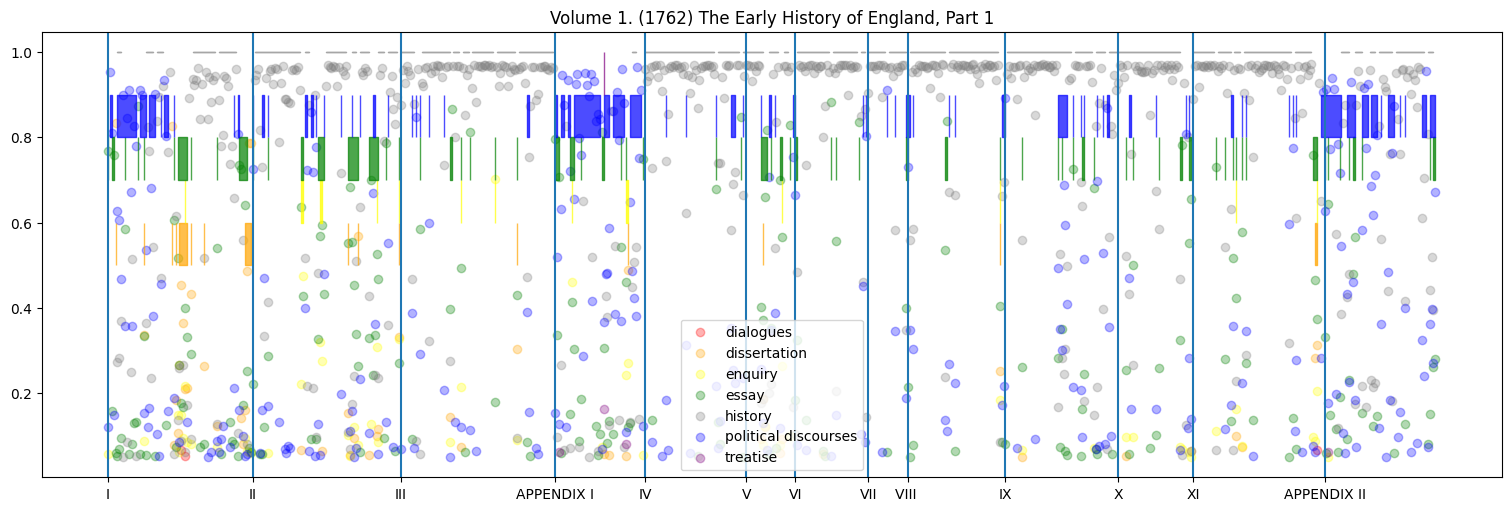

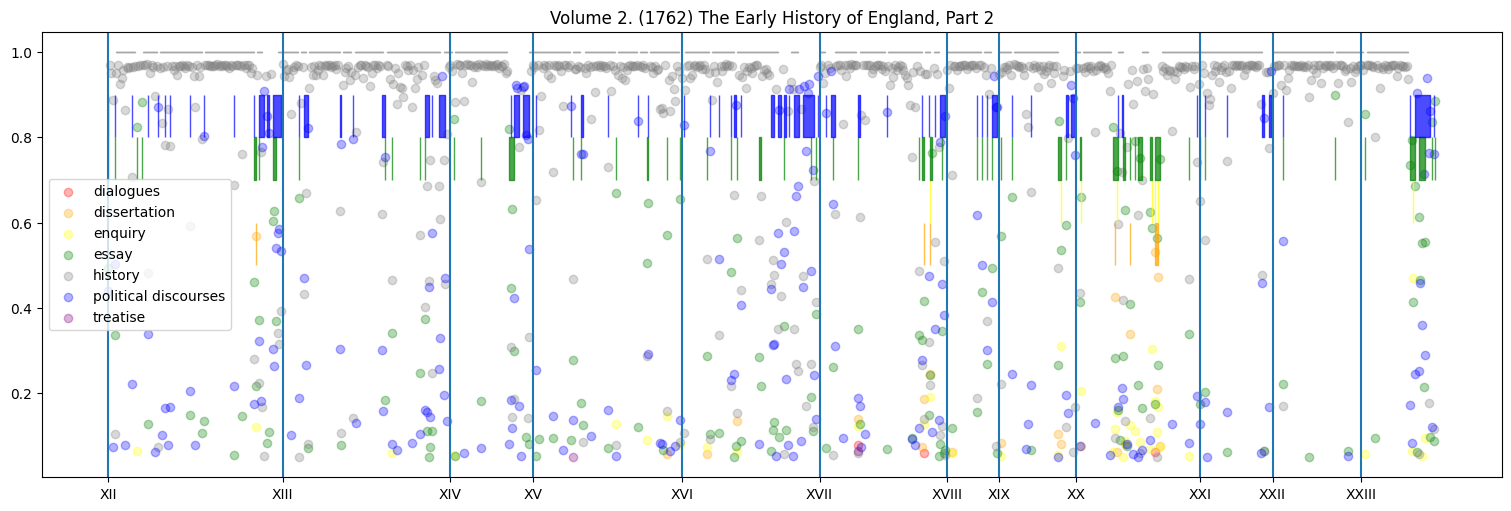

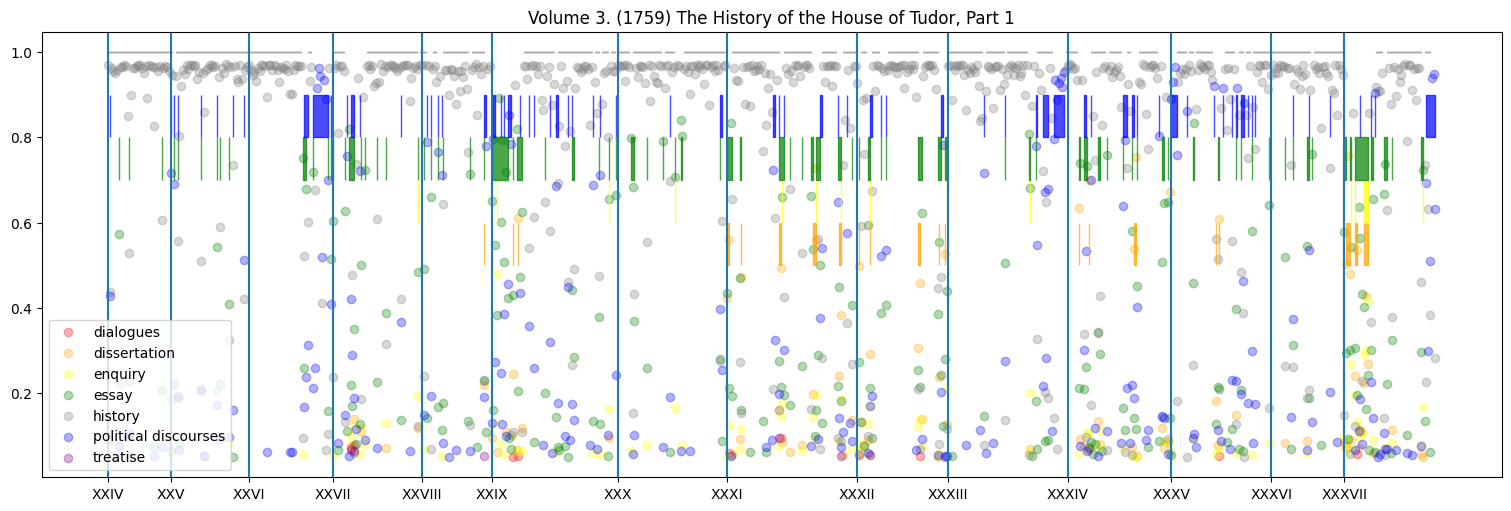

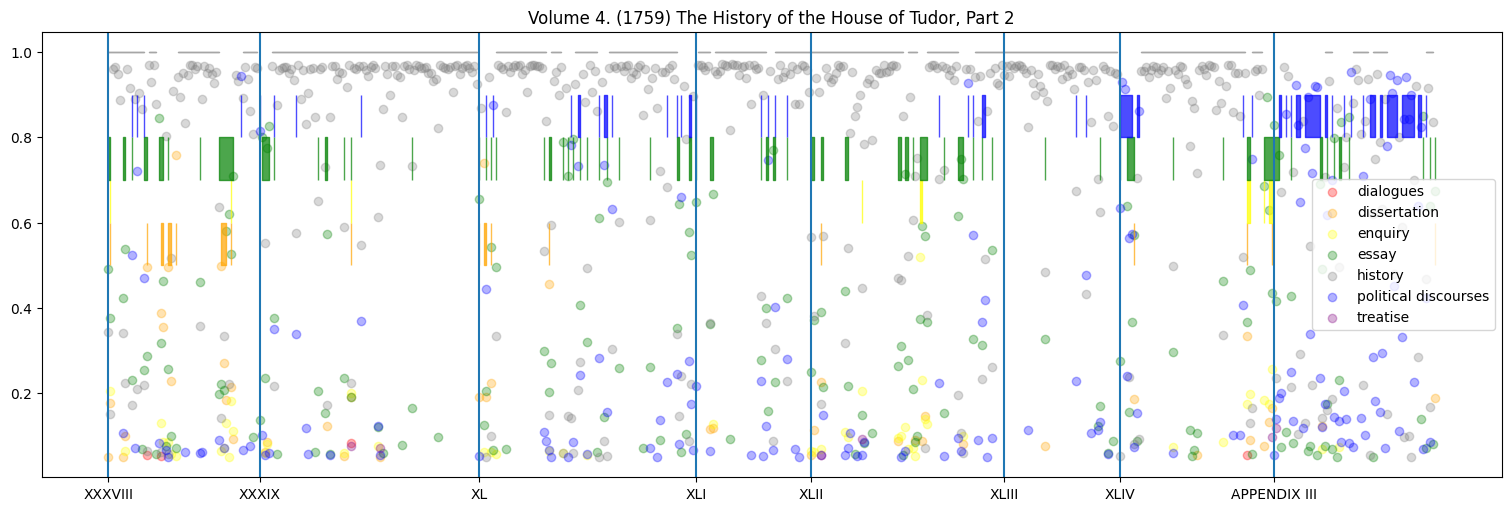

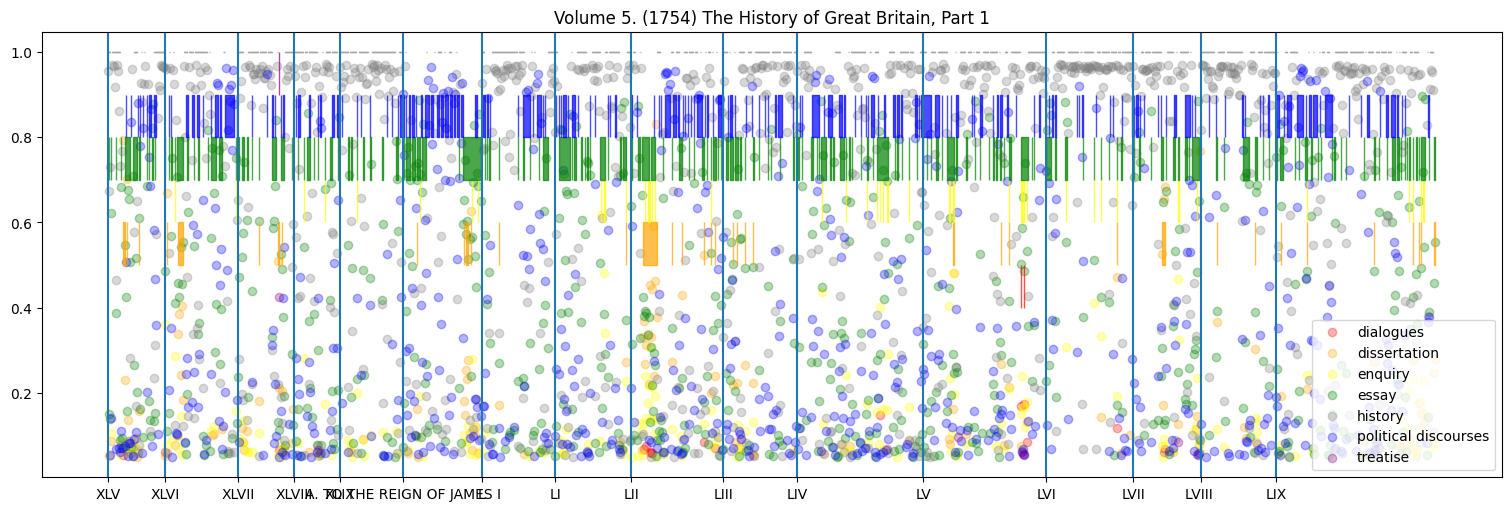

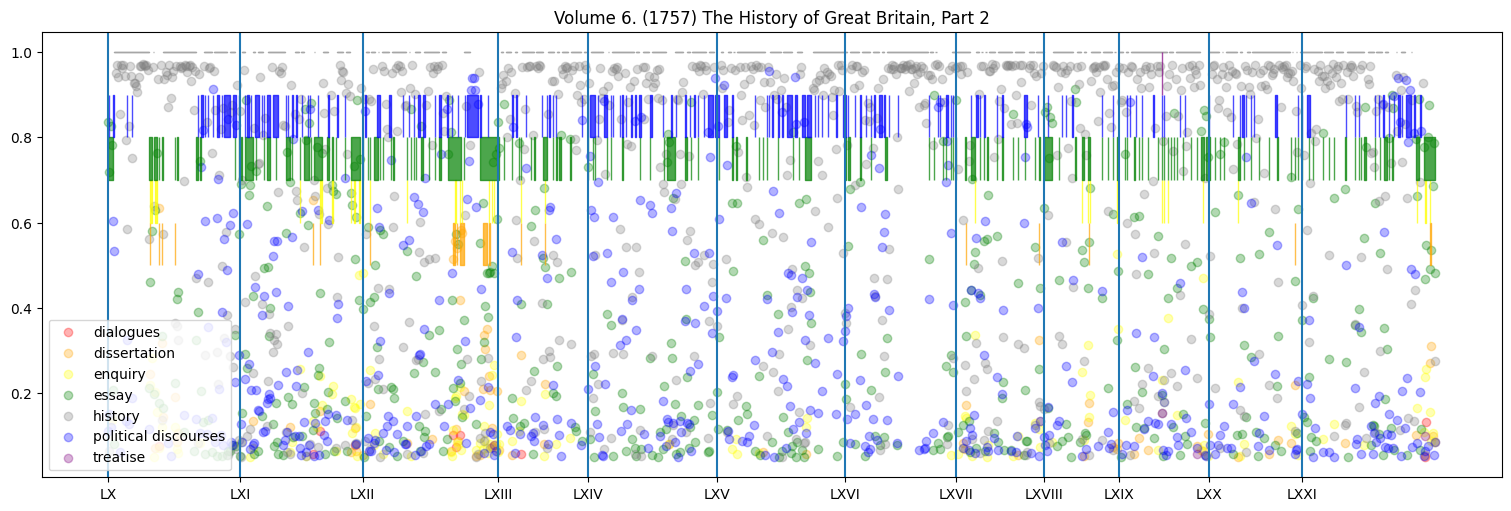

In [14]:
for i in range(1, 7):
    draw_volume(i, pred=pred_transformer)

## Additional table

In [15]:
def find_chapter(beginning):
    chapter_starts = list(titles_inv.keys())
    
    for i in range(len(chapter_starts)):
        if chapter_starts[i] > beginning:
            ch = titles_inv[chapter_starts[i-1]]
            return ch
        elif chapter_starts[i] == beginning:
            ch = titles_inv[chapter_starts[i]]
            return ch
    ch = titles_inv[chapter_starts[-1]]
    return ch

In [16]:
def volume_to_start(volume):
    
    d = {0:0, 
        1:708,
        2:1500,
        3:2245,
        4:2797,
        5:4006}
    
    return d[volume]

In [17]:
pred = pred_transformer
extracted_bursts = []
total = 0
for volume in range(0, 6): # normal order
    for genre_id in range(0, 7):
        if genre_id == 4:
            continue
        lefts, rights = extract_bursts(volume, genre_id, pred)
        total += len(lefts)
        for l, r in zip(lefts, rights):
            extracted_bursts.append((volume, genre_id, l, r))

In [18]:
df = pd.DataFrame(extracted_bursts, columns=['volume', 'genre', 'left', 'right'])
df['burst_len'] = df['right'] - df['left'] + 1
df['volume_number'] = df['volume']
df['volume'] = df['volume'].apply(lambda x: volume_names_short[x])
df['genre'] = df['genre'].apply(lambda x: id2label[x])
# добавить к номеру параграфа число в зависимости от книги
df['add_to_paragraph_number'] = df['volume_number'].apply(volume_to_start)
df['full_paragraph_number'] = df['left'] + df['add_to_paragraph_number']
# приписать номер главы и номер параграфа в главе
df['chapter'] = df['full_paragraph_number'].apply(find_chapter)
df['chapter_start'] = df['chapter'].apply(lambda x: titles_d[x])
df['start_in_chapter'] = df['full_paragraph_number'] - df['chapter_start']

In [19]:
df.to_csv('extracted_bursts/extracted_full_transformer.csv')

In [20]:
df[['volume', 'genre', 'burst_len', 'chapter', 'start_in_chapter']].sort_values(by='burst_len', ascending=False)[:20]

,volume,genre,burst_len,chapter,start_in_chapter
744,Volume 5 (1754),essay,17,A. TO THE REIGN OF JAMES I,55
1180,Volume 6 (1757),essay,16,LXII,92
99,Volume 1 (1762),political discourses,15,APPENDIX I,10
663,Volume 5 (1754),dissertation,14,LII,11
100,Volume 1 (1762),political discourses,12,XI,68
746,Volume 5 (1754),essay,11,LIV,73
745,Volume 5 (1754),essay,11,LI,3
101,Volume 1 (1762),political discourses,11,I,5
1181,Volume 6 (1757),essay,11,LXII,67
937,Volume 5 (1754),political discourses,10,LIV,113


In [21]:
df[['volume', 'genre', 'burst_len', 'chapter', 'start_in_chapter']].to_csv('extracted_bursts/extracted_transformer.csv')

In [22]:
aggregated = pd.DataFrame()
aggregated['volume'] = volume_names_short
aggregated = aggregated.set_index('volume')
aggregated['n_bursts'] = list(df.groupby(['volume']).count()['left'])
aggregated['n_paragraphs'] = list(df[['volume', 'burst_len']].groupby(['volume']).sum()['burst_len'])
aggregated['years'] = [1762, 1762.5, 1759, 1759.5, 1754, 1757]
aggregated['total_n_paragraphs'] = [708, 792, 745, 552, 1209, 1040]
aggregated['percentage_paragraphs'] = aggregated['n_paragraphs'] / aggregated['total_n_paragraphs']
aggregated = aggregated.sort_values(by=['years'])

In [23]:
aggregated

,n_bursts,n_paragraphs,years,total_n_paragraphs,percentage_paragraphs
volume,,,,,
Volume 5 (1754),467,924,1754.0,1209,0.764268
Volume 6 (1757),380,662,1757.0,1040,0.636538
Volume 3 (1759),195,318,1759.0,745,0.426846
Volume 4 (1759),142,226,1759.5,552,0.409420
Volume 1 (1762),179,337,1762.0,708,0.475989
Volume 2 (1762),145,245,1762.5,792,0.309343


<Axes: xlabel='volume'>

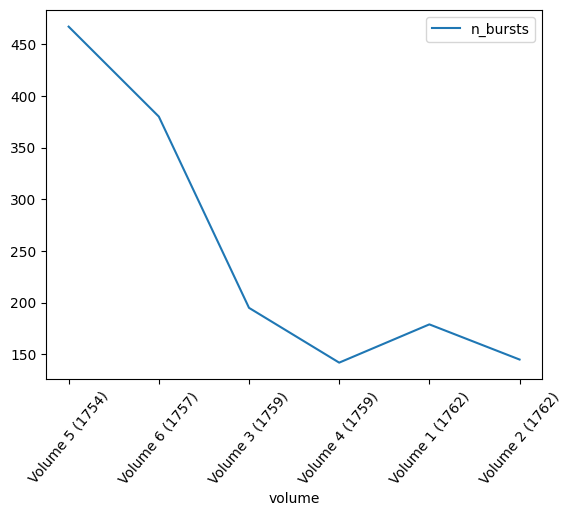

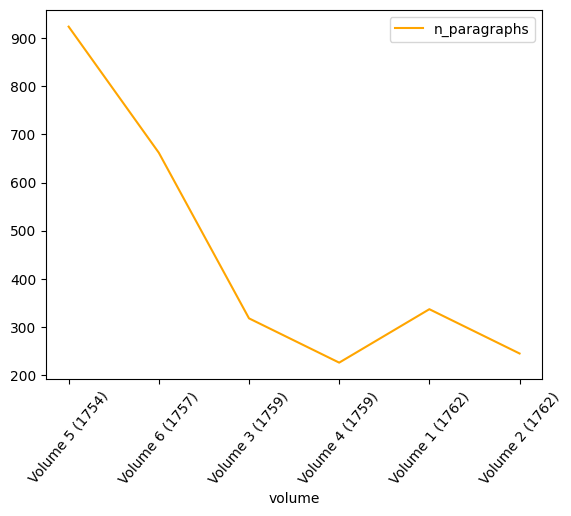

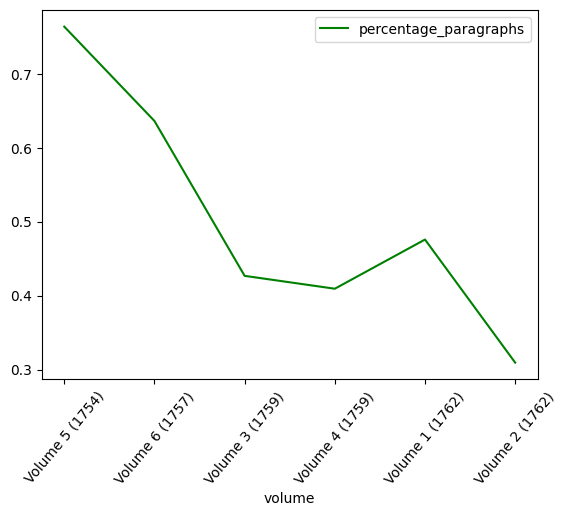

In [24]:
aggregated[['n_bursts']].plot.line(rot=50)
aggregated[['n_paragraphs']].plot.line(rot=50, color='orange')
aggregated[['percentage_paragraphs']].plot.line(rot=50, color='green')

In [25]:
df.groupby(['volume', 'genre'])['burst_len'].sum().to_csv('extracted_bursts/history_genres_aggregation.csv')

In [26]:
df.groupby(['volume', 'genre'])['burst_len'].sum()

volume           genre               
Volume 1 (1762)  dissertation             24
                 enquiry                  16
                 essay                   114
                 political discourses    182
                 treatise                  1
Volume 2 (1762)  dissertation              8
                 enquiry                   8
                 essay                    90
                 political discourses    139
Volume 3 (1759)  dissertation             34
                 enquiry                  16
                 essay                   147
                 political discourses    121
Volume 4 (1759)  dissertation             22
                 enquiry                  11
                 essay                   110
                 political discourses     83
Volume 5 (1754)  dialogues                 2
                 dissertation             66
                 enquiry                  52
                 essay                   419
                 